In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lifelines -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
TRAIN_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/sequential_feature_selection_features_updated_train_new.csv"
TEST_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/sequential_feature_selection_features_updated_test_new.csv"

In [ ]:
import pandas as pd
# load the training data
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

,C20orf22,ADCK2,ARL5B,BMPR1A,BMS1P1,FRA10AC1,OGFOD3,SPDL1,CCNJ,CD81,...,SMCP,SNORA36B,UNC93B1,WIPF3,ZNF22,ZNF248,FLJ23404,ZNF676,Disease Free (Months),DFS_STATUS_ENCODED
0,1.1084,0.1381,-1.3015,-0.3298,-0.8790,-0.2001,0.2880,-0.6509,-0.3501,1.3306,...,-1.2819,-47.5219,0.3042,-0.8972,-0.7499,-1.2925,-0.3176,-1.1132,8.41,1.0
1,-0.1005,0.5212,-0.2573,-0.4503,-0.2721,0.5470,-0.0534,-1.0111,-0.0342,-0.3876,...,-1.2819,-47.5219,0.4726,1.0643,-1.4436,0.4544,0.5857,-0.5119,2.56,1.0
2,0.3004,-0.9082,-0.1168,-0.3587,0.8405,-0.7239,-0.1667,0.8176,0.9477,-0.2253,...,-1.2819,-47.5219,0.5460,-0.8035,0.0617,-0.0401,0.2981,-0.5328,1.22,0.0
3,-0.4013,0.7237,-0.7190,-0.3022,0.4796,0.0019,-0.3718,-0.0256,-0.8363,-0.1055,...,-1.2819,-47.5219,0.9282,1.8169,-0.8905,-0.2346,0.3443,-0.7956,13.40,1.0
4,-0.3392,-0.0252,1.1848,0.8085,0.5990,1.4794,-1.6423,0.4705,1.6616,-1.3079,...,-1.2819,-47.5219,-0.2614,-0.1870,0.2724,1.1534,1.3512,-0.8140,3.19,1.0


In [ ]:
#Drop cols based on convergence

columns_to_drop = ['KRTAP9-4', 'OR2T2', 'OR4F17', 'SNORA36B']
train_data.drop(columns_to_drop, axis=1, inplace = True)

Cross-validation

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import numpy as np
def apply_cross_validation(df:pd.DataFrame, penalty: float = 0.1) -> None:
    # create the folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores = []
    # run cross validation
    for train_index, val_index in kf.split(train_data):
        train_fold = df.iloc[train_index]
        val_fold = df.iloc[val_index]
        cph = CoxPHFitter(penalizer = penalty)
        cph.fit(train_fold, duration_col='Disease Free (Months)', event_col='DFS_STATUS_ENCODED')
        val_predictions = cph.predict_partial_hazard(val_fold)
        c_index = concordance_index(val_fold['Disease Free (Months)'], -val_predictions, val_fold['DFS_STATUS_ENCODED'])
        c_index_scores.append(c_index)
    print(f"Average Validation C-index: {np.mean(c_index_scores)}")

In [ ]:
apply_cross_validation(train_data, penalty = 1)

Average Validation C-index: 0.7142801154928813


Train the model on the entire training set with the best parameter

In [ ]:
# Train the final model on the entire training set
cph_final = CoxPHFitter(penalizer = 0)
# fit on train data
cph_final.fit(train_data, duration_col='Disease Free (Months)', event_col='DFS_STATUS_ENCODED')
cph_final.print_summary()
# Concordance Index
c_index = cph_final.concordance_index_
print(f"Concordance Index: {c_index}")

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column GLT6D1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['DFS_STATUS_ENCODED'].astype(bool)
>>> print(df.loc[events, 'GLT6D1'].var())
>>> print(df.loc[~events, 'GLT6D1'].var())

A very low variance means that the column GLT6D1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.318. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separa

<lifelines.CoxPHFitter: fitted with 73 total observations, 17 right-censored observations>
             duration col = 'Disease Free (Months)'
                event col = 'DFS_STATUS_ENCODED'
      baseline estimation = breslow
   number of observations = 73
number of events observed = 56
   partial log-likelihood = -129.51
         time fit was run = 2025-01-25 21:29:52 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
C20orf22      -1.74      0.18      0.58           -2.88           -0.60                0.06                0.55
ADCK2          0.46      1.59      0.79           -1.09            2.02                0.33                7.55
ARL5B         -1.98      0.14      0.81           -3.56           -0.40                0.03                0.67
BMPR1A        -0.90      0.41      0.60           -2.09            0.28                0.12                1.33
BMS1P1         1.46      4.31      0.62            0.24            2.68                1.27               14.64
FRA10AC1       0.20      1.23      0.91           -1.57            1.98                0.21                7.27
OGFOD3         1.48      4.41      0.56            0.39            2.58                1.48               13.15
SPDL1          0.41      1.51      0.44           -0.46            1.28                0.63                3.60
CCNJ           0.00      1.00      0.85           -1.67            1.68                0.19                5.35
CD81           2.78     16.15      1.06            0.71            4.85                2.04              128.16
CHID1          1.49      4.45      0.68            0.15            2.83                1.17               16.99
CSGALNACT2     1.82      6.17      0.80            0.25            3.38                1.29               29.47
DDX58          2.40     10.99      0.90            0.62            4.17                1.87               64.74
EPC1           0.12      1.13      0.75           -1.35            1.60                0.26                4.97
FBXO27         0.53      1.70      0.36           -0.17            1.23                0.85                3.41
GLT6D1        -6.62      0.00   1281.42        -2518.16         2504.93                0.00                 inf
GNB2          -1.07      0.34      0.44           -1.93           -0.20                0.14                0.82
HFM1          -0.70      0.50      0.35           -1.38           -0.02                0.25                0.98
IRF7          -2.00      0.14      0.83           -3.63           -0.36                0.03                0.70
JMJD1C        -0.26      0.77      0.61           -1.46            0.94                0.23                2.56
LCORL          0.64      1.90      1.06           -1.44            2.72                0.24               15.25
LGALS3BP      -0.09      0.92      0.92           -1.89            1.72                0.15                5.60
ZEB1-AS1      -0.24      0.79      0.53           -1.28            0.81                0.28                2.24
LINC00669     -0.91      0.40      0.45           -1.79           -0.03                0.17                0.97
MOSPD3        -0.00      1.00      0.63           -1.24            1.23                0.29                3.44
MTPAP         -0.74      0.48      0.84           -2.39            0.92                0.09                2.50
MUL1          -1.07      0.34      0.56           -2.17            0.03                0.11                1.03
MYH4           0.19      1.21      1.29           -2.34            2.73                0.10               15.26
NAA35          0.87      2.40      0.50           -0.11            1.86                0.89                6.43
NAPSB          0.94      2.56      0.57           -0.18            2.06                0.83                7.86
PARP12        -1.40      0.25    

Concordance Index: 0.8789323164918971


Hazard ratio

In [ ]:
hazard_ratio = cph_final.hazard_ratios_
hazard_ratios_sort = hazard_ratio.sort_values()

Draw bar plot

<Axes: title={'center': 'Hazard Ratio vs. Covariate'}, xlabel='covariate', ylabel='Hazard Ratio'>

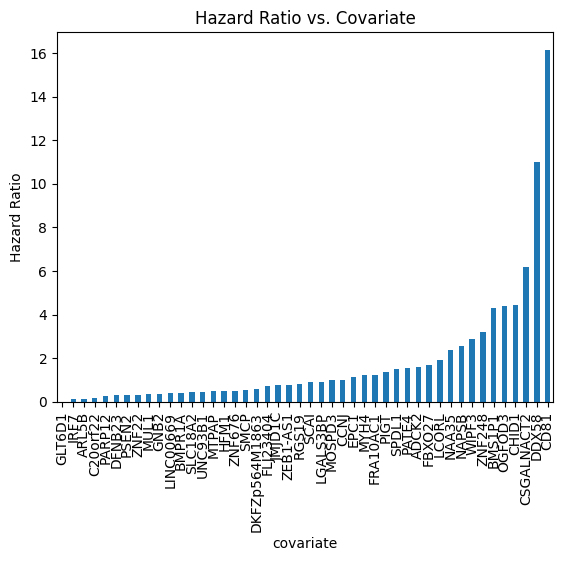

In [ ]:
hazard_ratios_sort.plot.bar(ylabel="Hazard Ratio", title="Hazard Ratio vs. Covariate")

Test data evaluation

In [ ]:
# read the test data
test_data = pd.read_csv(TEST_PATH)
print(test_data.shape)
test_data.head()

(19, 52)


,C20orf22,ADCK2,ARL5B,BMPR1A,BMS1P1,FRA10AC1,OGFOD3,SPDL1,CCNJ,CD81,...,SMCP,SNORA36B,UNC93B1,WIPF3,ZNF22,ZNF248,FLJ23404,ZNF676,Disease Free (Months),DFS_STATUS_ENCODED
0,1.0818,2.2594,-0.4877,-0.9739,-2.8018,-0.8582,2.6619,-0.0280,-1.3207,0.8436,...,-1.2819,-47.5219,1.9913,-0.2361,0.2942,-2.1451,-1.6352,-1.1132,13.11,1.0
1,-1.5285,-0.0349,-0.3291,0.3876,-0.6546,-0.9684,-0.1675,0.5215,0.0472,-2.5123,...,-1.2819,-47.5219,0.0130,1.0985,0.3499,-0.5196,-0.2263,0.0096,5.19,1.0
2,-0.2477,0.8714,-0.0946,0.0878,0.3905,0.5494,0.4926,1.2267,0.2387,-0.4058,...,-1.2819,-47.5219,0.2100,-0.9505,-0.3369,-0.3830,-0.0708,-0.5737,9.40,0.0
3,-0.4197,-0.6773,0.0611,0.5972,-1.1171,-0.9208,-0.2007,1.0097,0.3548,-0.6095,...,-0.7841,-47.5219,-0.0466,0.8833,0.6896,-0.4969,0.1592,-0.8014,4.86,1.0
4,0.0365,-2.0200,1.5867,1.6212,1.2540,0.5406,0.9227,-0.2251,1.0868,-0.3580,...,-1.2819,-47.5219,-0.7015,-0.4965,0.1924,1.1109,0.9264,0.4539,1.87,1.0


In [ ]:
test_risk_score = cph_final.predict_partial_hazard(test_data)
test_c_index = concordance_index(test_data['Disease Free (Months)'], -test_risk_score, test_data['DFS_STATUS_ENCODED'])
print(test_c_index)

0.6623376623376623


<Axes: title={'center': 'Risk Score vs. Individual'}, ylabel='Risk Score'>

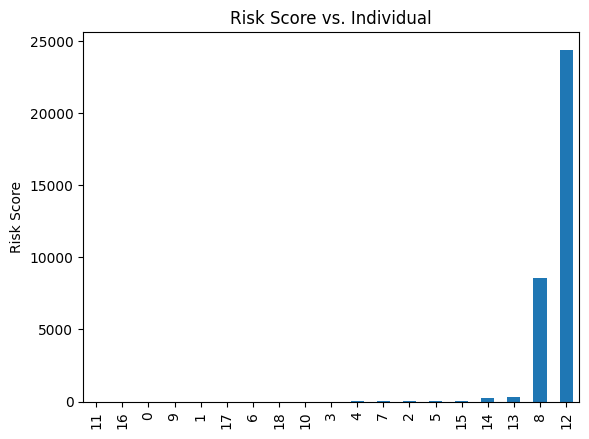

In [ ]:
sorted_risk_score = test_risk_score.sort_values()
sorted_risk_score.plot.bar(ylabel="Risk Score", title="Risk Score vs. Individual")

Survival probabilities

In [ ]:
survival_probabilities = cph_final.predict_survival_function(test_data, times=test_data["Disease Free (Months)"].to_list())
survival_probabilities_sorted = survival_probabilities.sort_index()
survival_probabilities_sorted.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1.12,0.999998,0.999989,0.999566,0.999957,0.999752,0.998799,0.999974,0.999713,0.371356,0.999995,0.999959,1.0,5.937384e-02,0.963298,0.974655,0.994991,0.999998,0.999976,0.999967
1.87,0.999995,0.999977,0.999057,0.999907,0.999461,0.997389,0.999944,0.999375,0.115954,0.999990,0.999910,1.0,2.150507e-03,0.921889,0.945693,0.989137,0.999996,0.999949,0.999928
2.20,0.999994,0.999968,0.998690,0.999871,0.999251,0.996374,0.999922,0.999132,0.050111,0.999986,0.999876,1.0,1.967378e-04,0.893152,0.925354,0.984939,0.999994,0.999929,0.999900
2.37,0.999991,0.999952,0.998030,0.999806,0.998874,0.994552,0.999883,0.998694,0.011089,0.999979,0.999813,1.0,2.670077e-06,0.843720,0.889881,0.977436,0.999991,0.999893,0.999850
2.69,0.999982,0.999908,0.996265,0.999632,0.997863,0.989686,0.999777,0.997524,0.000195,0.999959,0.999645,1.0,2.639793e-11,0.724310,0.801368,0.957609,0.999983,0.999797,0.999714


In [ ]:
from tabulate import tabulate
import pandas as pd


# Print the first few rows in a tabular format
def print_survival_table_lifelines(survival_probabilities_sorted):
    # Convert the DataFrame to a list of lists for tabulate
    headers = ["Time (Months)"] + [f"Patient {i}" for i in range(survival_probabilities_sorted.shape[1])]
    rows = []

    # Iterate over the DataFrame and prepare rows with time and survival probabilities
    for time, row in survival_probabilities_sorted.iterrows():
        row_data = [f"{time:.2f}"] + [f"{value:.4f}" for value in row]
        rows.append(row_data)

    # Print using tabulate
    print(tabulate(rows, headers=headers, tablefmt="grid"))

# Call the function to print the table
print_survival_table_lifelines(survival_probabilities_sorted)


+-----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|   Time (Months) |   Patient 0 |   Patient 1 |   Patient 2 |   Patient 3 |   Patient 4 |   Patient 5 |   Patient 6 |   Patient 7 |   Patient 8 |   Patient 9 |   Patient 10 |   Patient 11 |   Patient 12 |   Patient 13 |   Patient 14 |   Patient 15 |   Patient 16 |   Patient 17 |   Patient 18 |
+=================+=============+=============+=============+=============+=============+=============+=============+=============+=============+=============+==============+==============+==============+==============+==============+==============+==============+==============+==============+
|            1.12 |      1      |      1      |      0.9996 |      1      |      0.9998 |      0.9988 |      1     

Plot survival analysis

In [ ]:
import matplotlib.colors as mcolors
import random

def generate_random_colors(n):
    # Get a list of all matplotlib color names
    color_names = list(mcolors.CSS4_COLORS.keys())
    # Check if the requested number of colors is greater than the available colors
    if n > len(color_names):
        raise ValueError(f"Requested number of colors exceeds available colors ({len(color_names)}).")
    # Select n random colors
    random_colors = random.sample(color_names, n)
    return random_colors

def generate_interpolation(id, index, intervals):
    time_occured = test_data["Disease Free (Months)"].to_list()
    intersection = np.interp(time_occured[index], intervals, survival_probabilities_sorted[id])
    return intersection

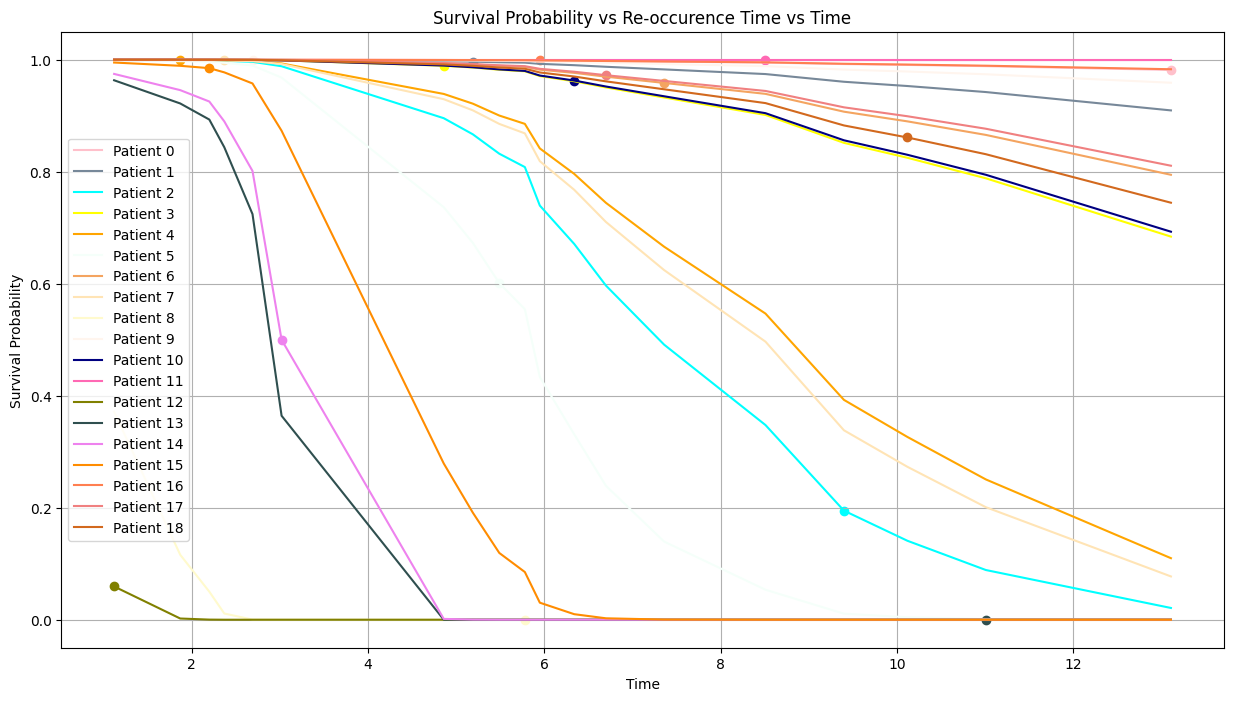

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# patients
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)
color_palatte = generate_random_colors(len(patients_id))
time_occured = test_data["Disease Free (Months)"].to_list()
plt.figure(figsize = (15,8))
for index, id in enumerate(patients_id):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(), label = f"Patient {id}", color = color_palatte[index])
    plt.scatter(x = time_occured[index], y = generate_interpolation(id, index, time_intervals), color = color_palatte[index])
plt.legend(loc = "best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel('Survival Probability')
plt.title("Survival Probability vs Re-occurence Time vs Time")
plt.show()

**Visualization of 3 random patients**

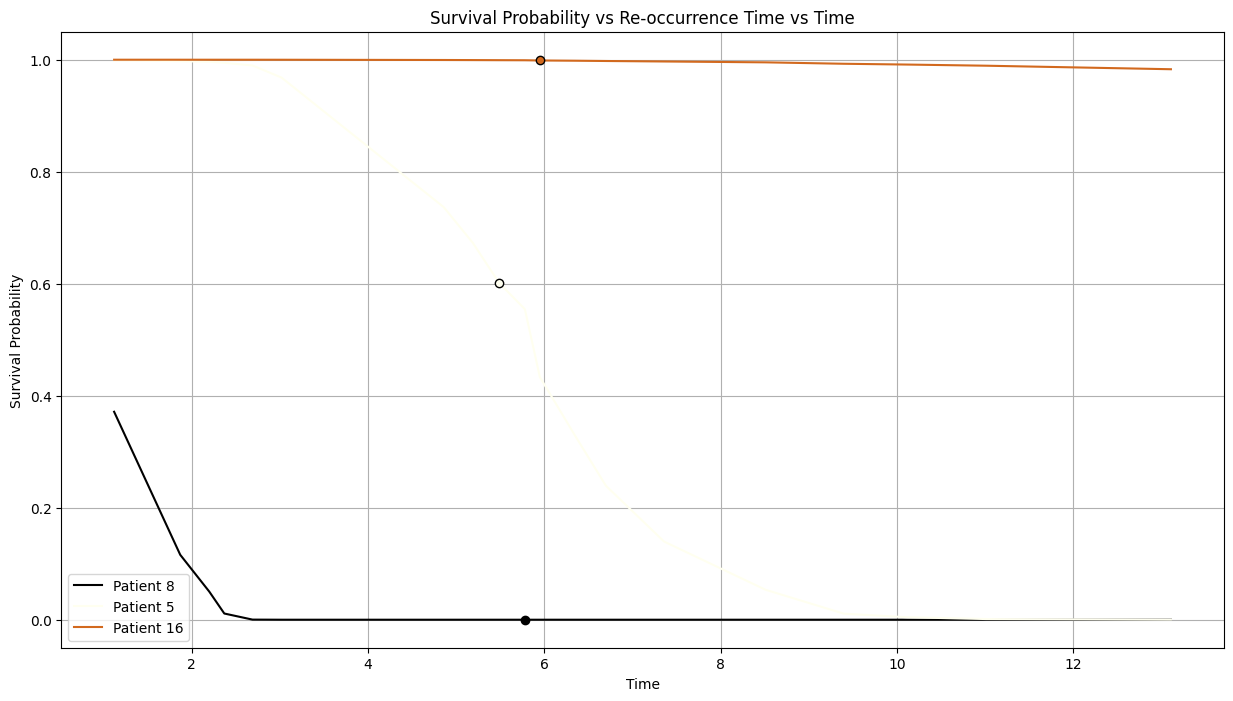

In [ ]:
# Get patient IDs and time intervals
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)

# Select 3 random patients
selected_patients = random.sample(patients_id, 3)
color_palette = generate_random_colors(len(selected_patients))

# Get the time occurred values from the test data
time_occured = test_data["Disease Free (Months)"].to_list()

# Create the plot
plt.figure(figsize=(15, 8))

for index, patient_id in enumerate(selected_patients):
    plt.plot(time_intervals, survival_probabilities_sorted[patient_id].to_list(),
             label=f"Patient {patient_id}", color=color_palette[index])
    # Plot dots on top of lines
    patient_index = patients_id.index(patient_id)
    plt.scatter(x=time_occured[patient_index],
                y=generate_interpolation(patient_id, patient_index, time_intervals),
                color=color_palette[index],edgecolor='black',zorder=5)

plt.legend(loc="best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability vs Re-occurrence Time vs Time")
plt.show()

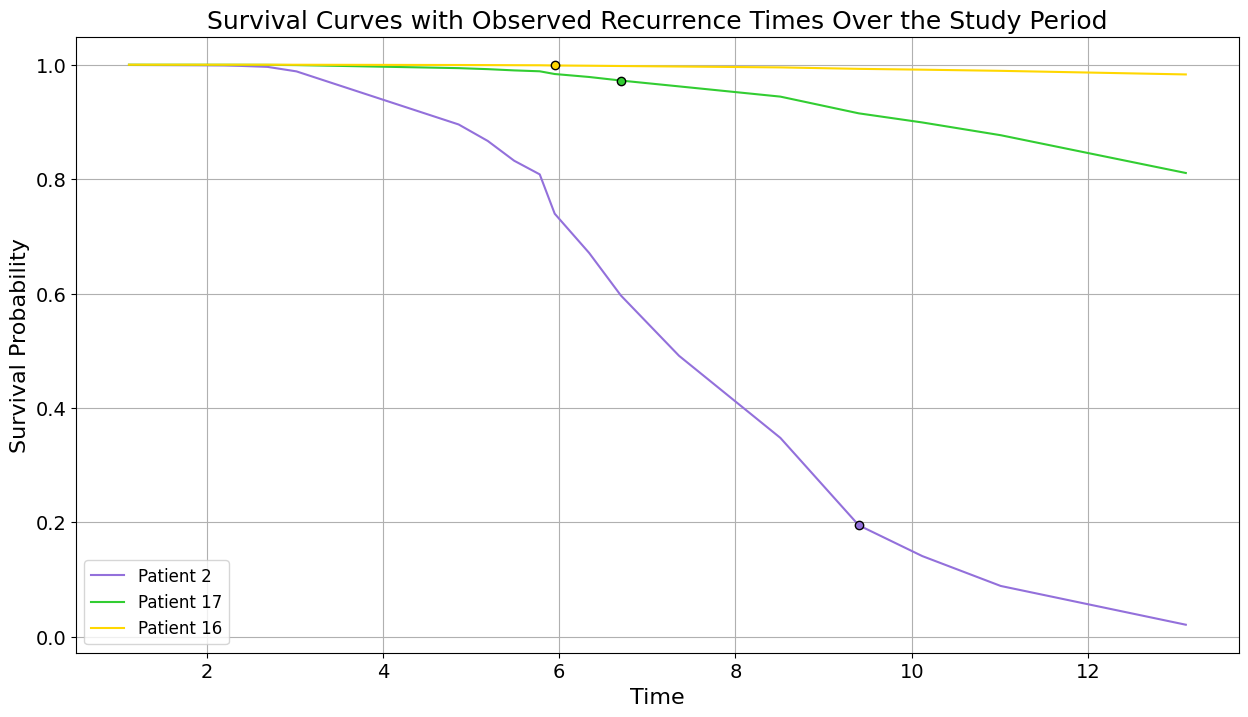

In [ ]:
# Visualization of 3 random Patients with DFS_STATUS_ENCODED = 0

# Get patient IDs and time intervals
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)

# Filter test_data for patients with DFS_STATUS_ENCODED == 0
filtered_data = test_data[test_data['DFS_STATUS_ENCODED'] == 0]
# Ensure we have at least 3 patients; otherwise, select all available patients
num_patients_to_select = min(3, len(filtered_data))
selected_patients = random.sample(list(filtered_data.index), num_patients_to_select)


# Initialize color palette for selected patients
color_palatte = generate_random_colors(len(selected_patients))

# Get the time occurred values from the test data
time_occured = test_data["Disease Free (Months)"].to_list()

# Plotting
plt.figure(figsize=(15, 8))
for index, id in enumerate(selected_patients):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(),
             label=f"Patient {id}", color=color_palatte[index])
    # Plot dots on top of lines
    patient_index = patients_id.index(id)
    plt.scatter(x=time_occured[patient_index], y=generate_interpolation(id, patient_index, time_intervals),
                color=color_palatte[index],edgecolor='black',zorder=5)


# Customize axis tick and label font sizes
plt.xticks(fontsize=14)  # Adjust x-axis tick font size
plt.yticks(fontsize=14)  # Adjust y-axis tick font size

plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Survival Probability", fontsize=16)
plt.title("Survival Curves with Observed Recurrence Times Over the Study Period", fontsize=18)
plt.show()

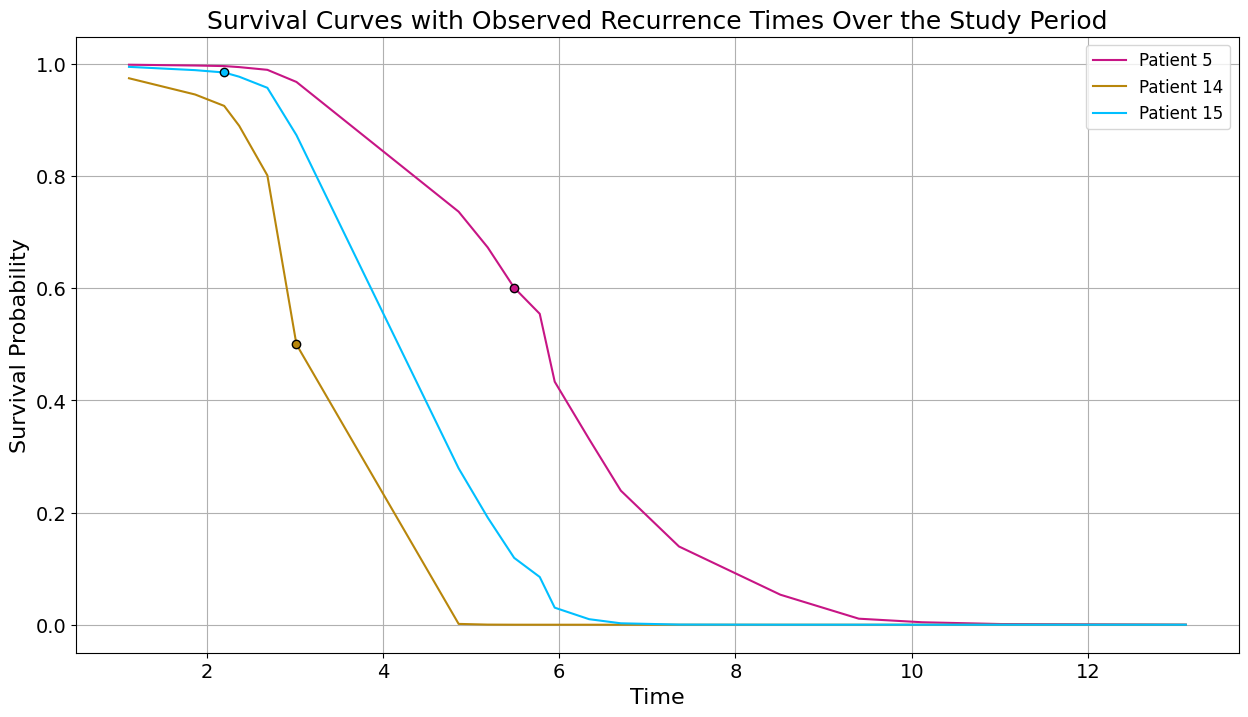

In [ ]:
# Visualization of Patients with selected pateint ids and with DFS_STATUS_ENCODED = 1


# Patient IDs to plot
#selected_patients = [1, 15, 19]
selected_patients = [5, 14, 15]

# Filter test_data for the selected patient IDs and ensure DFS_STATUS_ENCODED == 1
filtered_data = test_data[(test_data.index.isin(selected_patients))]

#print(test_data)

#print (filtered_data)

# Ensure we have the patients in survival_probabilities_sorted
selected_patients = [pid for pid in selected_patients if pid in survival_probabilities_sorted.columns]

# Get  time intervals
time_intervals = list(survival_probabilities_sorted.index)

# Initialize color palette for selected patients
color_palatte = generate_random_colors(len(selected_patients))

# Get the time occurred values from the test data
time_occured = test_data["Disease Free (Months)"].to_list()

# Plotting
plt.figure(figsize=(15, 8))
for index, id in enumerate(selected_patients):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(),
             label=f"Patient {id}", color=color_palatte[index])
    # Plot dots on top of lines
    patient_index = patients_id.index(id)
    plt.scatter(x=time_occured[patient_index], y=generate_interpolation(id, patient_index, time_intervals),
                color=color_palatte[index],edgecolor='black',zorder=5)

# Customize axis tick and label font sizes
plt.xticks(fontsize=14)  # Adjust x-axis tick font size
plt.yticks(fontsize=14)  # Adjust y-axis tick font size

plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Survival Probability", fontsize=16)
plt.title("Survival Curves with Observed Recurrence Times Over the Study Period", fontsize=18)
plt.show()

In [ ]:
survival_probabilities_train = cph_final.predict_survival_function(train_data, times=test_data["Disease Free (Months)"].to_list())
survival_probabilities_train_sorted = survival_probabilities_train.sort_index()
print(survival_probabilities_train_sorted.to_string())
survival_probabilities_train_sorted.to_csv("Cox SFS Train Survival Probability.csv", index=True)

             0              1         2         3             4         5         6         7         8             9         10            11        12        13        14        15            16        17        18             19        20        21        22        23        24        25             26             27        28        29        30             31        32        33            34            35        36        37            38   39            40            41        42        43            44            45        46             47            48        49        50        51        52        53        54            55            56        57        58        59             60             61        62        63        64            65   66        67        68        69   70            71        72
1.12   0.999249   9.149196e-01  0.999963  0.999963  9.976729e-01  0.999887  0.999987  0.999978  1.000000  9.948106e-01  0.999910  9.958619e-01  0.999894  0.999925  0.999851  1